In [1]:
import os

ROOT = "image"
KERNEL_SIZE = 640
STRIDE = 320
image_list_file = []
image_category = os.listdir(ROOT)

for category in image_category:
    image_lists = os.listdir("%s/%s" % (ROOT, category))
    
    for image in image_lists:
        if image.endswith(".txt"): continue
        image_list_file.append("%s/%s/%s" % (ROOT, category, image))

image_list_file.sort()

In [2]:
from ultralytics import YOLO

detector = YOLO("weights/epoch250.pt")

LABEL_LIST = detector.names

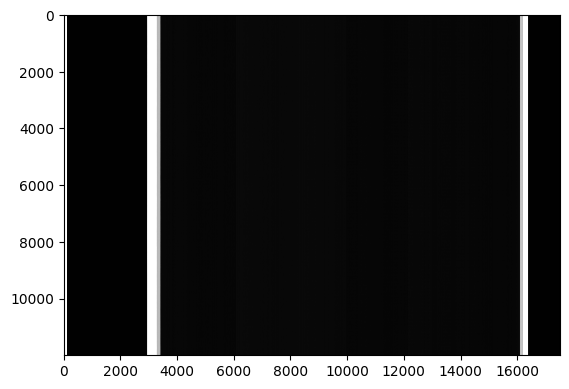

In [3]:
import cv2
import matplotlib.pyplot as plt

plt.imshow(cv2.imread(image_list_file[0]))
plt.show()

In [4]:
def sliding(image, kernel_size=640, stride=10):
    result = []
    for y in range(0, image.shape[0], stride):
        temp_image = image[y : y + kernel_size]
        rows_image = []
        
        for x in range(0, image.shape[1], stride):
            cropped = temp_image[:, x : x + kernel_size]
            rows_image.append(cropped)
            
            if cropped.shape[1] < KERNEL_SIZE: break
        
        result.append(rows_image)
        
        if temp_image.shape[0] < KERNEL_SIZE: break
    
    return result

In [5]:
# slided_image = sliding(image_list[0], KERNEL_SIZE, STRIDE)
# row = len(slided_image)
# col = len(slided_image[0])

# plt.figure(figsize=(100, 100))

# for i, row_data in enumerate(slided_image):
#     for j, image in enumerate(row_data):
#         plt.subplot(row, col, i * row + j + 1)
#         plt.imshow(image)

# plt.show()

In [6]:
# plt.imshow(slided_image[1][10])
# plt.show()

In [7]:
import threading
import time
import multiprocessing

class detectData():
    def __init__(self):
        self.x1 = 0
        self.x2 = 0
        self.y1 = 0
        self.y2 = 0
        self.cls = 0
        self.conf = 0

class PriorityQueue():
    def __init__(self):
        self.data = []
    
    def add(self, data):
        self.data.append(data)
        self.data.sort(key=lambda d: d.conf)
    
    def size(self):
        return len(self.data)
    
    def get(self, i):
        return self.data[i]
    
    def clear(self):
        self.data = []
    
    def to_array(self):
        return self.data

def overlap(x1, y1, x2, y2):
    l1 = x1 - y1 / 2
    l2 = x2 - y2 / 2
    left = l1 if l1 > l2 else l2
    
    r1 = x1 + y1 / 2
    r2 = x2 + y2 / 2
    right = r1 if r1 < r2 else r2
    
    return right - left

def box_intersection(a, b):
    w = overlap((a.x1 + a.x2) / 2, (a.x2 - a.x1),
                (b.x1 + b.x2) / 2, (b.x2 - b.x1))
                
    h = overlap((a.y1 + a.y2) / 2, (a.y2 - a.y1),
                (b.y1 + b.y2) / 2, (b.y2 - b.y1))
    
    if (w < 0 or h < 0): return 0
    
    return  w * h

def box_union(a, b):
    i = box_intersection(a, b)
    u = (a.x2 - a.x1) * (a.y2 - a.y1) + (b.x2 - b.x1) * (b.y2 - b.y1) - i
    return u

def box_iou(a, b):
    return box_intersection(a, b) / box_union(a, b)
    
def nms(detect_list):
    pq = PriorityQueue()
    nmsList = []
    
    pq = PriorityQueue()
        
    for i, detect in enumerate(detect_list):
        pq.add(detect)

    while pq.size() > 0:
        detections = pq.to_array()
        max = detections[-1]
        nmsList.append(max)
        pq.clear()

        for j, detection in enumerate(detections):
            if box_iou(max, detection) < 0.125:
                pq.add(detection)
    
    return nmsList

def detect_postprocessing(detections, stride):
    boxes = []
    
    spend = time.time()
    
    for i, detect_row in enumerate(detections):
        for j, detect in enumerate(detect_row):
            boxes_orig = detect.boxes.cpu().numpy()

            for box_list in boxes_orig:
                for box in box_list:
                    nbox = detectData()

                    x1, y1, x2, y2 = box.xyxy[0]

                    nbox.x1 = int(x1 + (j * stride))
                    nbox.x2 = int(x2 + (j * stride))
                    nbox.y1 = int(y1 + (i * stride))
                    nbox.y2 = int(y2 + (i * stride))
                    nbox.cls = int(box.cls[0])
                    nbox.conf = box.conf[0]
                    
                    boxes.append(nbox)
    
    print("spend: %fs | " % (time.time() - spend), end="")
    
    return boxes

def detectCrack(images_file):
    detections_final = []
    spend_time = 0
    cycles = 1
    
    def detect_processing(slided, stride):
        detection = []
        
        for image_row in slided:
            detection.append(detector(image_row, conf=0.50, verbose=False))
            
        postprocessed = detect_postprocessing(detection, stride)
        
        return postprocessed
    
    class saveImage(threading.Thread):
        def __init__(self, path, image):
            super().__init__()
            self.path = path
            self.image = image

        def run(self):
            cv2.imwrite(self.path, self.image)
    
    for i, image_file in enumerate(images_file):
        image = cv2.imread(image_file)
        #image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        
        start_time = time.time()
        
        detect_spend = time.time()
        #postprocessed_1 = detect_processing(sliding(image, KERNEL_SIZE // 4, STRIDE // 4), STRIDE // 4)
        postprocessed_3 = detect_processing(sliding(image, KERNEL_SIZE, STRIDE), STRIDE)
        postprocessed_4 = detect_processing(sliding(image, KERNEL_SIZE * 2, STRIDE * 2), STRIDE * 2)
        
        detect_spend = time.time() - detect_spend
        
        nms_spend = time.time()
        boxes = nms(postprocessed_3 + postprocessed_4)
        nms_spend = time.time() - nms_spend
    
        for box in boxes:
            cv2.putText(image, "%s %f%%" % (LABEL_LIST[box.cls], box.conf), (box.x1, box.y1-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255))
            cv2.rectangle(image, (box.x1, box.y1), (box.x2, box.y2), (0, 0, 255), 3)
            
        saveImage("detect/image-%d.png" % (i), image).start()
        
        spend_time += time.time() - start_time
        
        print("Complete: %d | avg spend_time: %fs | detect: %fs | nms: %fs" % (i, spend_time / cycles, detect_spend, nms_spend))
        cycles += 1
    
    return None

In [8]:
detections_result = detectCrack(image_list_file)

spend: 0.023485s | spend: 0.005401s | Complete: 0 | avg spend_time: 11.948686s | detect: 11.936663s | nms: 0.009822s
spend: 0.023819s | spend: 0.005599s | Complete: 1 | avg spend_time: 10.136317s | detect: 8.304097s | nms: 0.017396s
spend: 0.023972s | spend: 0.005440s | Complete: 2 | avg spend_time: 9.528677s | detect: 8.297705s | nms: 0.013326s
spend: 0.023301s | spend: 0.005570s | Complete: 3 | avg spend_time: 9.220578s | detect: 8.275391s | nms: 0.018371s
spend: 0.024021s | spend: 0.005556s | Complete: 4 | avg spend_time: 9.041259s | detect: 8.298504s | nms: 0.022775s
spend: 0.023327s | spend: 0.005726s | Complete: 5 | avg spend_time: 8.921848s | detect: 8.307763s | nms: 0.014616s
spend: 0.024570s | spend: 0.005443s | Complete: 6 | avg spend_time: 8.834624s | detect: 8.296368s | nms: 0.012685s
spend: 0.023178s | spend: 0.005412s | Complete: 7 | avg spend_time: 8.768641s | detect: 8.293109s | nms: 0.011484s
spend: 0.023744s | spend: 0.005687s | Complete: 8 | avg spend_time: 8.719566s

spend: 0.024246s | spend: 0.006016s | Complete: 71 | avg spend_time: 8.364743s | detect: 8.293063s | nms: 0.021039s
spend: 0.023741s | spend: 0.005747s | Complete: 72 | avg spend_time: 8.363760s | detect: 8.276621s | nms: 0.013921s
spend: 0.023748s | spend: 0.005638s | Complete: 73 | avg spend_time: 8.362983s | detect: 8.288386s | nms: 0.015423s
spend: 0.024351s | spend: 0.005925s | Complete: 74 | avg spend_time: 8.362443s | detect: 8.294007s | nms: 0.025264s
spend: 0.023840s | spend: 0.006011s | Complete: 75 | avg spend_time: 8.361719s | detect: 8.287924s | nms: 0.016891s
spend: 0.023880s | spend: 0.005913s | Complete: 76 | avg spend_time: 8.360382s | detect: 8.243412s | nms: 0.012881s
spend: 0.023027s | spend: 0.005746s | Complete: 77 | avg spend_time: 8.359066s | detect: 8.246741s | nms: 0.008820s
spend: 0.023942s | spend: 0.006379s | Complete: 78 | avg spend_time: 8.358093s | detect: 8.251308s | nms: 0.027923s
spend: 0.023688s | spend: 0.006316s | Complete: 79 | avg spend_time: 8.3

spend: 0.023704s | spend: 0.006115s | Complete: 142 | avg spend_time: 8.315989s | detect: 8.236623s | nms: 0.020174s
spend: 0.023159s | spend: 0.005912s | Complete: 143 | avg spend_time: 8.316048s | detect: 8.312254s | nms: 0.009780s
spend: 0.023237s | spend: 0.006099s | Complete: 144 | avg spend_time: 8.315482s | detect: 8.217835s | nms: 0.013611s
spend: 0.024386s | spend: 0.005918s | Complete: 145 | avg spend_time: 8.315282s | detect: 8.253777s | nms: 0.029310s
spend: 0.025201s | spend: 0.006074s | Complete: 146 | avg spend_time: 8.315194s | detect: 8.256093s | nms: 0.042744s
spend: 0.023588s | spend: 0.006065s | Complete: 147 | avg spend_time: 8.314724s | detect: 8.230277s | nms: 0.012938s
spend: 0.023431s | spend: 0.005970s | Complete: 148 | avg spend_time: 8.314237s | detect: 8.224923s | nms: 0.014693s
spend: 0.023311s | spend: 0.005753s | Complete: 149 | avg spend_time: 8.313781s | detect: 8.230663s | nms: 0.012851s
spend: 0.023717s | spend: 0.006180s | Complete: 150 | avg spend_

In [9]:
# import threading
# class saveImage(threading.Thread):
#    def __init__(self, path, image):
#         super().__init__()
#         self.path = path
#         self.image = image
    
#     def run(self):
#         cv2.imwrite(self.path, self.image)

# for i, (image_orig, boxes) in enumerate(zip(image_list, detections_result)):
#     image = image_orig.copy()
#     for box in boxes:
#         cv2.putText(image, "%s %f%%" % (LABEL_LIST[box.cls], box.conf), (box.x1, box.y1-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255))
#         cv2.rectangle(image, (box.x1, box.y1), (box.x2, box.y2), (0, 0, 255), 3)
    
#     saveImage("detect/image-%d.png" % (i), image).start()